In [11]:
N = 6
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
target_col = cols[N % 7]
print(target_col)

Time_on_Education


Итак, данные для обработки мы будем брать из столбца Time_on_Gaming датасета teen_phone_addiction_dataset.csv.

Подготовка.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from math import sqrt
from scipy.stats import norm, chi2

df = pd.read_csv('../datasets/teen_phone_addiction_dataset.csv', usecols=['Time_on_Education','School_Grade'])
data = df['Time_on_Education'].dropna().values
n = len(data)
print(data)


[1.2 1.8 0.4 ... 2.4 1.5 0.1]


Здание 1.


Характеристики (оригинальные данные)
Среднее: 1.0163
Дисперсия: 0.4202
Мода: 0.0 (встречается 250 раз)
Медиана: 1.0000
Квантили: Q1=0.5000, Q2=1.0000, Q3=1.5000
Эксцесс: -0.4000
Асимметрия: 0.3400
Интерквартильный размах: 1.0000


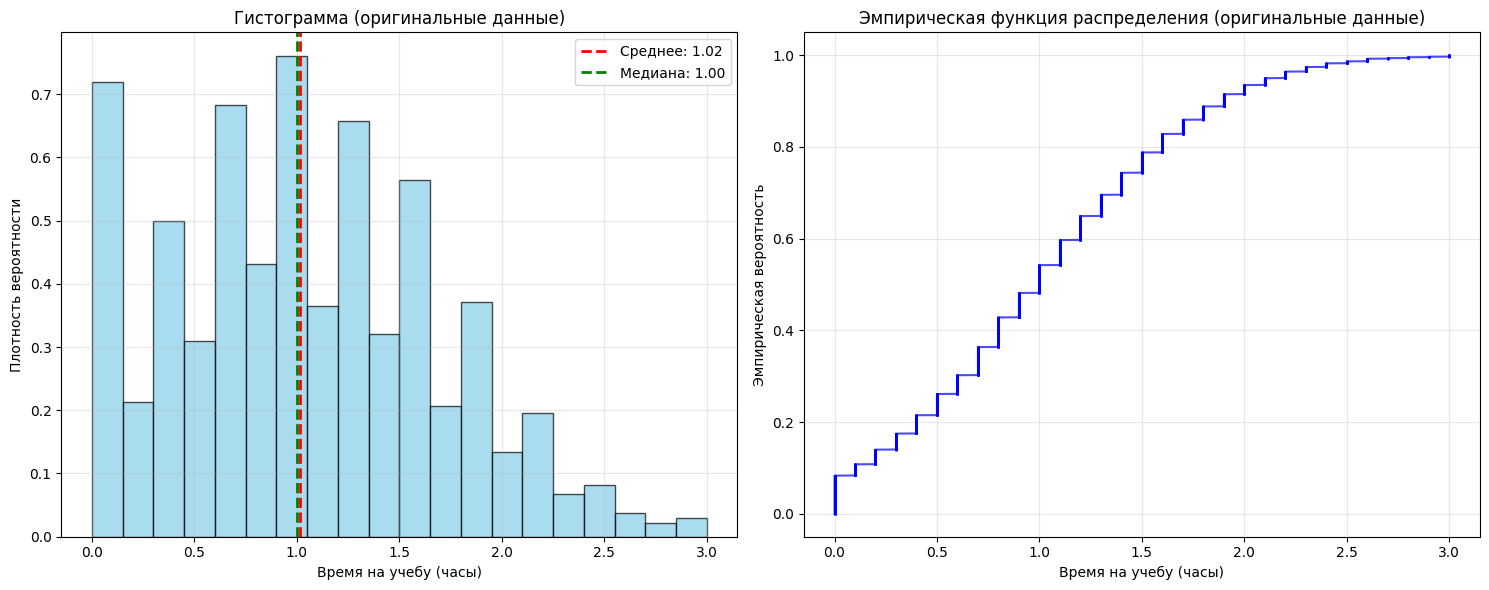

In [19]:
def descriptive_statistics(data, title_suffix="(оригинальные данные)"):
    ev = np.mean(data)
    varian = np.var(data)
    mod_result = stats.mode(data)
    median = np.median(data)
    quantile_25 = np.quantile(data, 0.25)
    quantile_50 = np.quantile(data, 0.50)
    quantile_75 = np.quantile(data, 0.75)
    exess = stats.kurtosis(data)
    skew = stats.skew(data)
    inter = quantile_75 - quantile_25

    print(f"\nХарактеристики {title_suffix}")
    print(f"Среднее: {ev:.4f}")
    print(f"Дисперсия: {varian:.4f}")
    print(f"Мода: {mod_result.mode} (встречается {mod_result.count} раз)")
    print(f"Медиана: {median:.4f}")
    print(f"Квантили: Q1={quantile_25:.4f}, Q2={quantile_50:.4f}, Q3={quantile_75:.4f}")
    print(f"Эксцесс: {exess:.4f}")
    print(f"Асимметрия: {skew:.4f}")
    print(f"Интерквартильный размах: {inter:.4f}")

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.hist(data, bins=20, alpha=0.7, edgecolor='black', density=True, color='skyblue')
    plt.axvline(ev, color='red', linestyle='--', linewidth=2, label=f'Среднее: {ev:.2f}')
    plt.axvline(median, color='green', linestyle='--', linewidth=2, label=f'Медиана: {median:.2f}')
    plt.xlabel('Время на учебу (часы)')
    plt.ylabel('Плотность вероятности')
    plt.title(f'Гистограмма {title_suffix}')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(data)
    plt.plot(x, y, marker='.', linestyle='-', color='blue', alpha=0.7, markersize=2)
    plt.xlabel('Время на учебу (часы)')
    plt.ylabel('Эмпирическая вероятность')
    plt.title(f'Эмпирическая функция распределения {title_suffix}')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return ev, varian, skew, exess

mean, var, skew, kurt = descriptive_statistics(data, "(оригинальные данные)")

Исходя из характеристик и гистограммы можно сделать вывод, что у нас правосторонняя асиметрия. Скорее у нас один пик (в районе 1) и просто аномальное скопление у 0, на что нам показывает мода. Так как у нас медиана почти равна среднему, делаем вывод, что у нас распределение почти симметричное (асиметрия > 0, значит правый хвост).

Задание 2.


Проверка нормальности

Критерий Хи-квадрат: хи-квадрат=3784.2094, критическое=68.6693, df=51
   → Отвергаем: распределение НЕ нормальное

Проверка по асимметрии/эксцессу: skew=0.3400, kurt=-0.4000
   Z_skew=7.60, Z_kurt=-4.47
   → Отвергаем: распределение НЕ нормальное


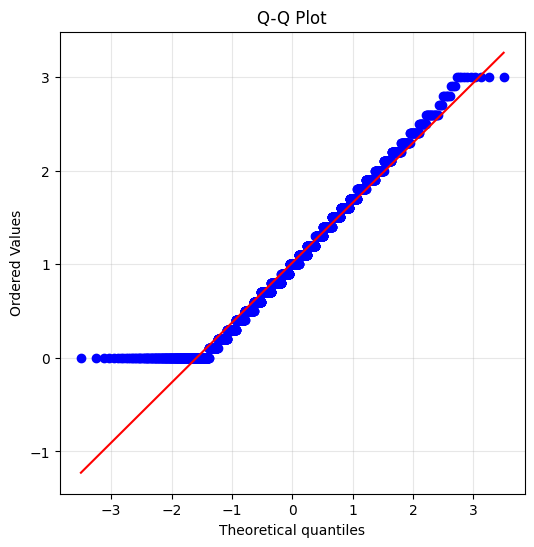

In [22]:
def normality_tests(data, mean, var):
    print("\nПроверка нормальности")

    k = int(np.sqrt(len(data)))
    bins = np.linspace(min(data), max(data), k+1)
    observed, _ = np.histogram(data, bins=bins)

    mu, sigma = mean, sqrt(var)
    expected = []
    for i in range(len(bins)-1):
        p = norm.cdf(bins[i+1], mu, sigma) - norm.cdf(bins[i], mu, sigma)
        expected.append(len(data)*p)
    expected = np.array(expected)
    expected = np.where(expected == 0, 1e-10, expected)

    chi2_stat = np.sum((observed - expected) ** 2 / expected)
    df_chi2 = k - 3
    critical = chi2.ppf(0.95, df_chi2)
    print(f"\nКритерий Хи-квадрат: хи-квадрат={chi2_stat:.4f}, критическое={critical:.4f}, df={df_chi2}")
    if chi2_stat > critical:
        print("   → Отвергаем: распределение НЕ нормальное")
    else:
        print("   → Принимаем: распределение нормальное")

    skew = stats.skew(data)
    kurt = stats.kurtosis(data)
    z_skew = skew / sqrt(6/len(data))
    z_kurt = kurt / sqrt(24/len(data))
    print(f"\nПроверка по асимметрии/эксцессу: skew={skew:.4f}, kurt={kurt:.4f}")
    print(f"   Z_skew={z_skew:.2f}, Z_kurt={z_kurt:.2f}")
    if abs(z_skew) <= 2 and abs(z_kurt) <= 2:
        print("   → Принимаем: распределение нормальное")
    else:
        print("   → Отвергаем: распределение НЕ нормальное")

    plt.figure(figsize=(6, 6))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title("Q-Q Plot")
    plt.grid(alpha=0.3)
    plt.show()

normality_tests(data, mean, var)

Исходя из результатов, все тесты на нормальность отвергают гипотезу о нормальном распределении данных. График Q-Q также показывает, что на концах наблюдаемое распределение отличается от нормального.

Задание 3.


Характеристики (без выбросов)
Среднее: 1.0163
Дисперсия: 0.4202
Мода: 0.0 (встречается 250 раз)
Медиана: 1.0000
Квантили: Q1=0.5000, Q2=1.0000, Q3=1.5000
Эксцесс: -0.4000
Асимметрия: 0.3400
Интерквартильный размах: 1.0000


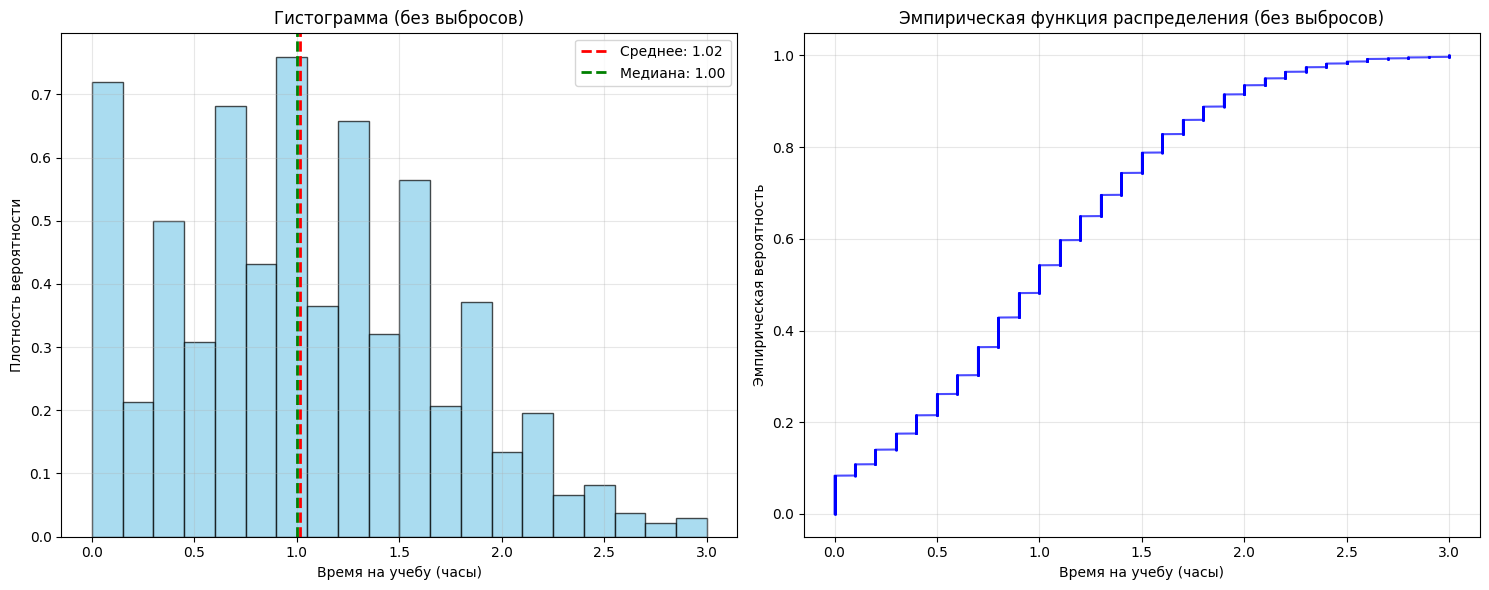


Проверка нормальности

Критерий Хи-квадрат: хи-квадрат=3784.2094, критическое=68.6693, df=51
   → Отвергаем: распределение НЕ нормальное

Проверка по асимметрии/эксцессу: skew=0.3400, kurt=-0.4000
   Z_skew=7.60, Z_kurt=-4.47
   → Отвергаем: распределение НЕ нормальное


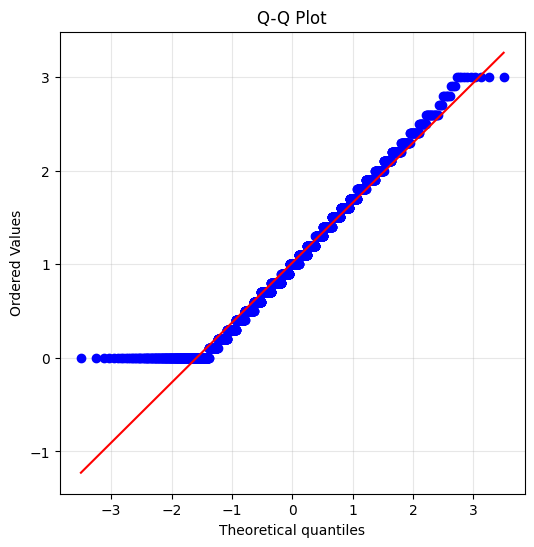


Характеристики (логарифмированные)
Среднее: 0.6468
Дисперсия: 0.1136
Мода: 0.0 (встречается 250 раз)
Медиана: 0.6931
Квантили: Q1=0.4055, Q2=0.6931, Q3=0.9163
Эксцесс: -0.6516
Асимметрия: -0.3188
Интерквартильный размах: 0.5108


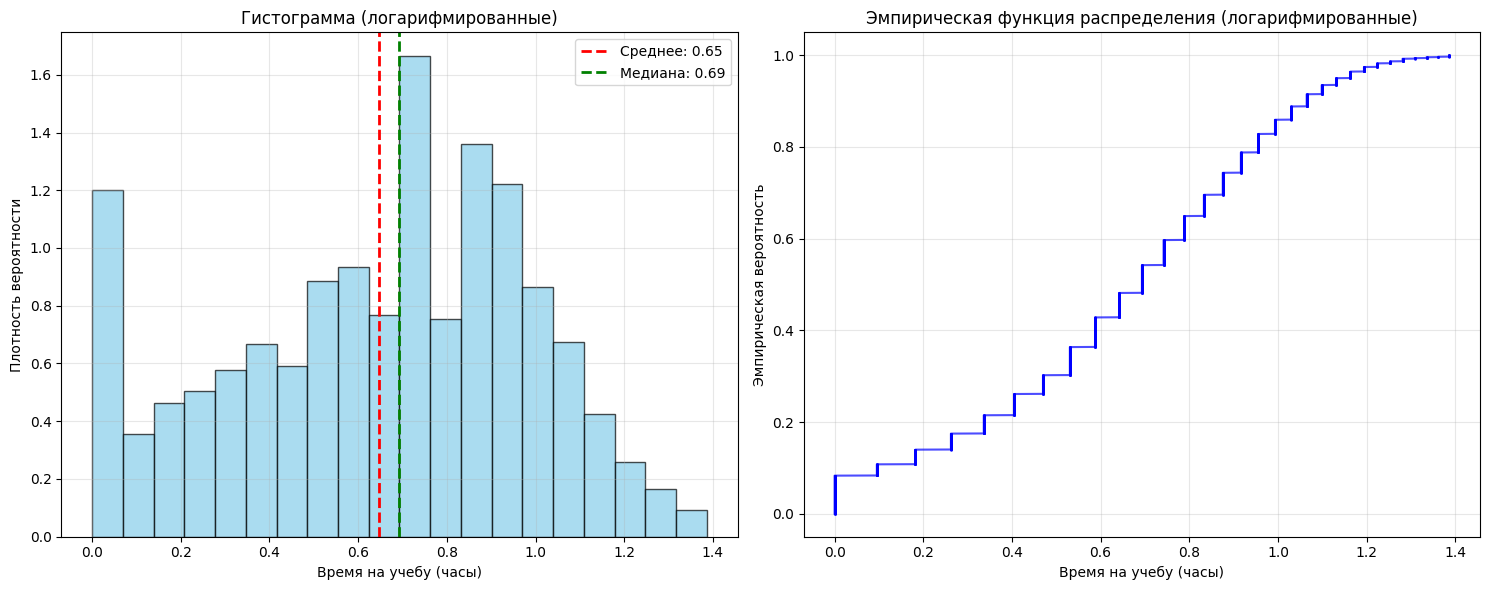


Проверка нормальности

Критерий Хи-квадрат: хи-квадрат=6240.2417, критическое=68.6693, df=51
   → Отвергаем: распределение НЕ нормальное

Проверка по асимметрии/эксцессу: skew=-0.3188, kurt=-0.6516
   Z_skew=-7.13, Z_kurt=-7.29
   → Отвергаем: распределение НЕ нормальное


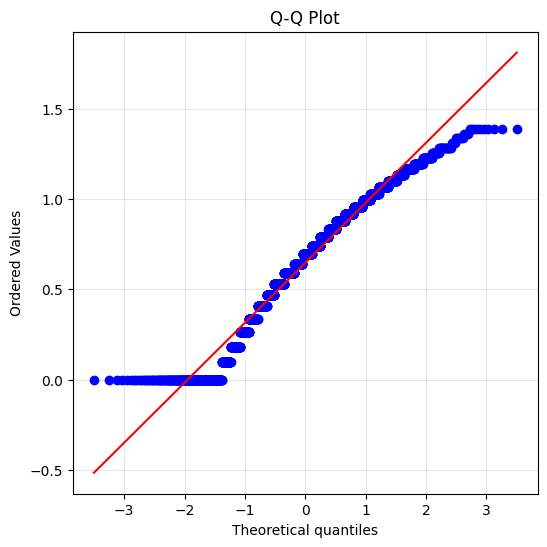


Характеристики (стандартизированные)
Среднее: 0.0000
Дисперсия: 1.0000
Мода: -1.5678508937991074 (встречается 250 раз)
Медиана: -0.0252
Квантили: Q1=-0.7965, Q2=-0.0252, Q3=0.7461
Эксцесс: -0.4000
Асимметрия: 0.3400
Интерквартильный размах: 1.5427


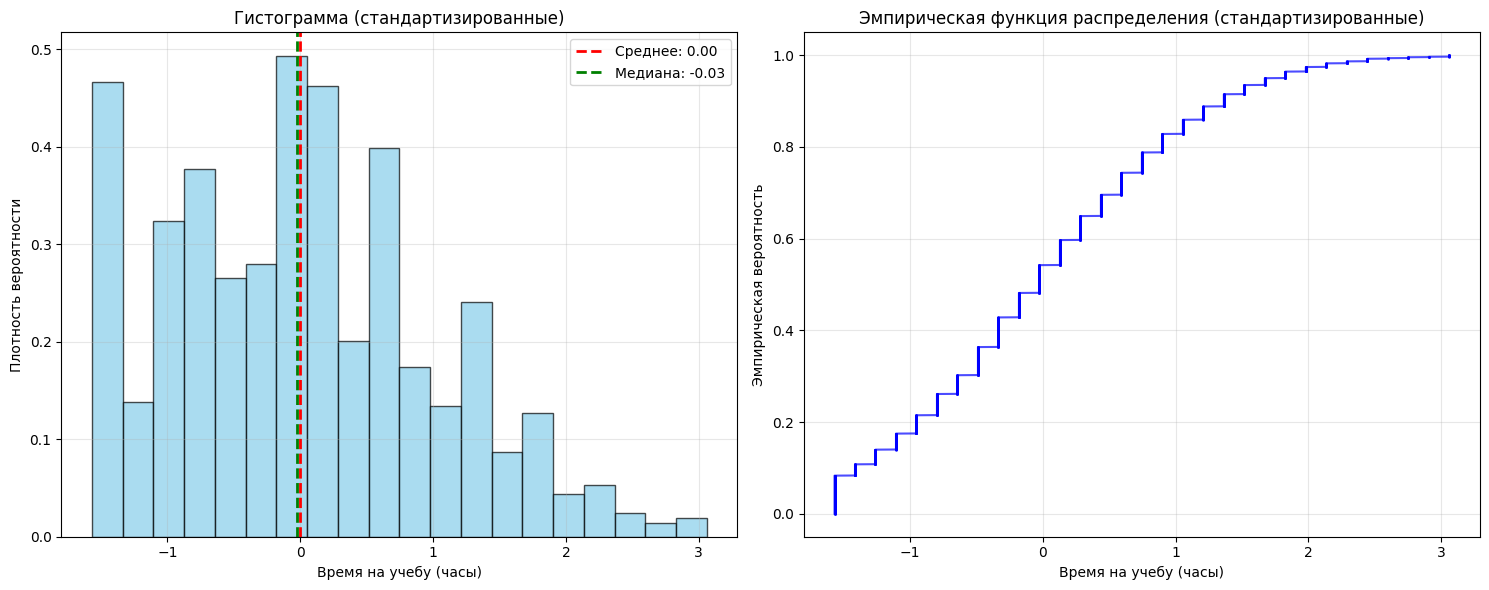


Проверка нормальности

Критерий Хи-квадрат: хи-квадрат=3769.6333, критическое=68.6693, df=51
   → Отвергаем: распределение НЕ нормальное

Проверка по асимметрии/эксцессу: skew=0.3400, kurt=-0.4000
   Z_skew=7.60, Z_kurt=-4.47
   → Отвергаем: распределение НЕ нормальное


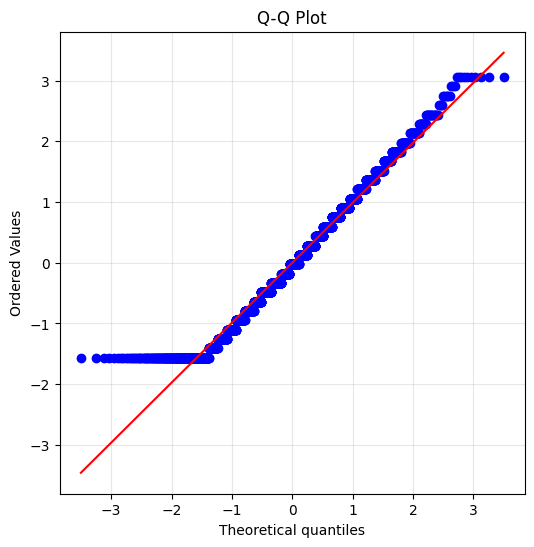

In [24]:
def preprocess_and_analyze(data, method):
    if method == "remove_outliers":
        q1, q3 = np.quantile(data, 0.25), np.quantile(data, 0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        new_data = data[(data >= lower) & (data <= upper)]
    elif method == "log":
        new_data = np.log1p(data)
    elif method == "standardize":
        new_data = (data - np.mean(data)) / np.std(data)
    else:
        raise ValueError("Неизвестный метод")

    title_map = {
        "remove_outliers": "(без выбросов)",
        "log": "(логарифмированные)",
        "standardize": "(стандартизированные)"
    }
    mean, var, skew, kurt = descriptive_statistics(new_data, title_suffix=title_map[method])
    normality_tests(new_data, mean, var)

preprocess_and_analyze(data, "remove_outliers")
preprocess_and_analyze(data, "log")
preprocess_and_analyze(data, "standardize")

Проверки без выбросов и нормировка не дали никаких результатов. А вот логарифмирование сделало наше распределение более явным унимодальным. НО графики и характиристики у логарифмирования при этом еще больше отдалили нас от нормального распределения.

Задание 4.


Класс 10th: Среднее=1.0285, Дисперсия=0.4478

Класс 11th: Среднее=0.9916, Дисперсия=0.4090

Класс 12th: Среднее=1.0240, Дисперсия=0.3996

Класс 7th: Среднее=1.0213, Дисперсия=0.4175

Класс 8th: Среднее=0.9753, Дисперсия=0.4230

Класс 9th: Среднее=1.0527, Дисперсия=0.4220


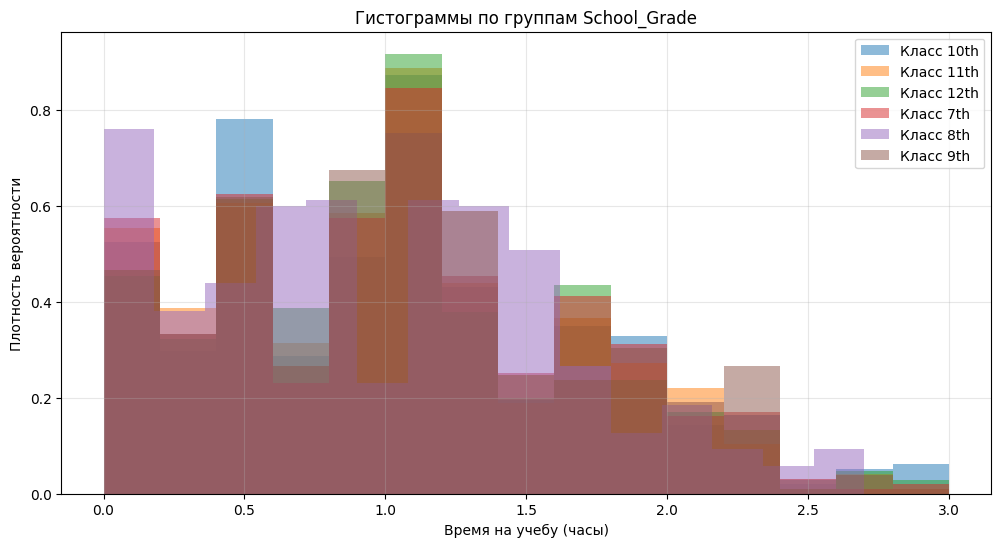

In [26]:
def analyze_by_group(df):
    groups = df.groupby('School_Grade')['Time_on_Education']

    plt.figure(figsize=(12, 6))
    for grade, group in groups:
        plt.hist(group, bins=15, alpha=0.5, density=True, label=f'Класс {grade}')
        mean, var = np.mean(group), np.var(group)
        print(f"\nКласс {grade}: Среднее={mean:.4f}, Дисперсия={var:.4f}")

    plt.xlabel("Время на учебу (часы)")
    plt.ylabel("Плотность вероятности")
    plt.title("Гистограммы по группам School_Grade")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

analyze_by_group(df)

Исходя из построенных гистограмм и полученным статистикам по группам можно предположить, что в большинстве данные приходят из похожих (по крайней мере внешне) распределений, только явно выделяется 8 класс, потому что у него тень графика заметно отличается и главный пик в 0. Также стоит выделить 10 класс, потому что, хотя и плохо видно, но у него главный пик тоже находится не там, где у большинства. Однако на мой взгляд это показывает, что 8 и 10 класс распределил время на учебу более унимодально, чем остальные классы, у которых есть аномальное число в 0. Среднее и дисперсия варьируется, что может указывать на возмоное влияние номера класса на время, проведенное за учебой.